In [1]:
#実行してない
#コード確認してね
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import re
import scipy.spatial.distance as distance
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import openpyxl

def df_spline_resample(df, n_samples):
    """
    DataFrameをスプライン補間を用いて再サンプリングする関数
    """
    original_length = len(df)
    new_index = np.linspace(0, original_length - 1, n_samples)
    resampled_data = np.zeros((n_samples, df.shape[1]))
    for i in range(df.shape[1]):
        spl = interp.splrep(np.arange(original_length), df.iloc[:, i], k=3)
        resampled_data[:, i] = interp.splev(new_index, spl)
    resampled_df = pd.DataFrame(resampled_data, columns=df.columns)
    return resampled_df

# グラフの保存先ディレクトリ
graph_save_path = r"E:\てすりとキネクト（てすり）\データ分析\階層型クラスタリング"

# CSVファイルが格納されているディレクトリを指定
dataList = glob.glob(r"E:\てすりとキネクト（てすり）\データ分析\分析用抽出データ/*.csv")

# ファイル名の入ったリスト
namelist = []
data_num = 0

# データの処理
for data in tqdm(dataList):
    try:
        dfdata = pd.read_csv(data, header=None, index_col=None, usecols=[2, 3, 4])
        unidf = df_spline_resample(dfdata, 300)
        name_component = re.split("[./]", data)
        unidf.to_excel(os.path.join(graph_save_path, "Unified" + name_component[-2] + ".xlsx"), index=False)
        data_num += 1
        namelist.append(name_component[-2])
    except Exception as e:
        print(f"Error processing {data}: {e}")

# 距離行列の初期化
Dis_Mat = np.eye(data_num)
Unified_data_list = glob.glob("E:/てすりとキネクト（てすり）/データ分析/階層型クラスタリング/Unified*.xlsx")
col = 0

# データの差分計算
for Unified_data in tqdm(Unified_data_list):
    data = pd.read_excel(Unified_data, engine='openpyxl')
    row = 0
    for com_Unified_data in Unified_data_list:
        com_data = pd.read_excel(com_Unified_data, engine='openpyxl')
        Diff = data - com_data
        Diff_mat = Diff.values
        Diff_mat_split = np.split(Diff_mat, 1, 1)
        Dis_Mat[col:col + 1, row:row + 1] = np.sum(np.sqrt(np.diag(np.dot(Diff_mat_split[0], Diff_mat_split[0].T))))
        row += 1
    col += 1

# 距離行列の保存
Dis_all = pd.DataFrame(Dis_Mat, columns=namelist, index=namelist)
Dis_all.to_excel("E:/てすりとキネクト（てすり）/データ分析/階層型クラスタリング/Distance.xlsx")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:06<00:00,  4.21s/it]


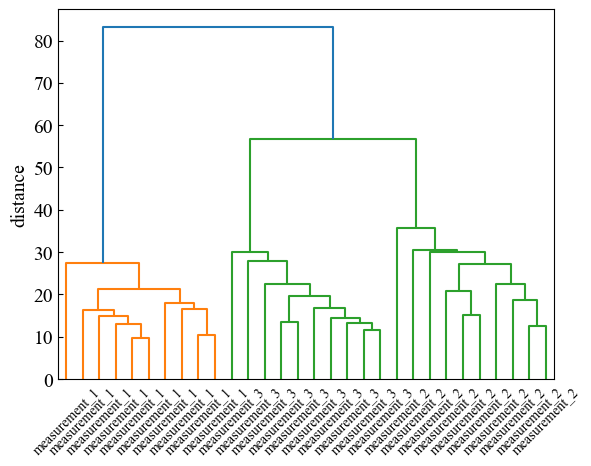

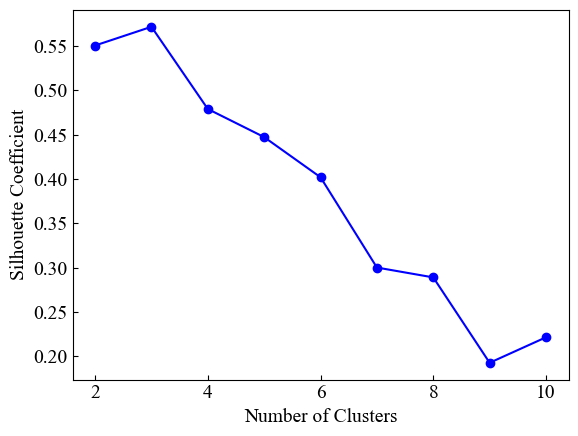

silhouette_coefficient
[0.5507793831633381, 0.5719309222306658, 0.47906632772086133, 0.4473053588803006, 0.4019466277447291, 0.29998634380063577, 0.2888449068611231, 0.1923970555703461, 0.2211988893983604]


In [3]:
# 階層型クラスタリング(平均法)
# デンドログラムとシルエット係数

# 表示名に変換する関数を定義
def convert_display_name(filename):
    if "force1" in filename:
        return "measurement_3"
    elif "force2" in filename:
        return "measurement_2"
    elif "force3" in filename:
        return "measurement_1"
    else:
        return filename

# デンドログラムに表示する名前を変換
display_names = [convert_display_name(name) for name in namelist]
                 
# クラスタリングとデンドログラムの作成
Distance = Dis_all.values
darray = distance.squareform(Distance)
result = linkage(darray, method="average")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
fig = plt.figure()
dendrogram(result, labels=display_names)
plt.ylabel("distance")

# グラフの保存
graph_file_name = os.path.join(graph_save_path, "handrail_dendrogram.png")
plt.savefig(graph_file_name)
plt.show()

# シルエット係数の計算とプロット
plt.cla()
NUM_CLUSTERS_RANGE = range(2, 11)
silhouette_coefficient = []
davies_bouldin_index = []

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.direction"] = "in"

for num in NUM_CLUSTERS_RANGE:
    labels = fcluster(result, t=num, criterion="maxclust")
    silhouette_coefficient.append(silhouette_score(Distance, labels, metric="precomputed"))
    davies_bouldin_index.append(davies_bouldin_score(Distance, labels))

p0, = plt.plot(NUM_CLUSTERS_RANGE, silhouette_coefficient, 'bo-', label="Silhouette Coefficient")
lines = [p0]

graph_file_name = os.path.join(graph_save_path, "handrail_dendrogram_silhouette_coefficient.png")
plt.savefig(graph_file_name)
plt.show()

print("silhouette_coefficient")
print(silhouette_coefficient)


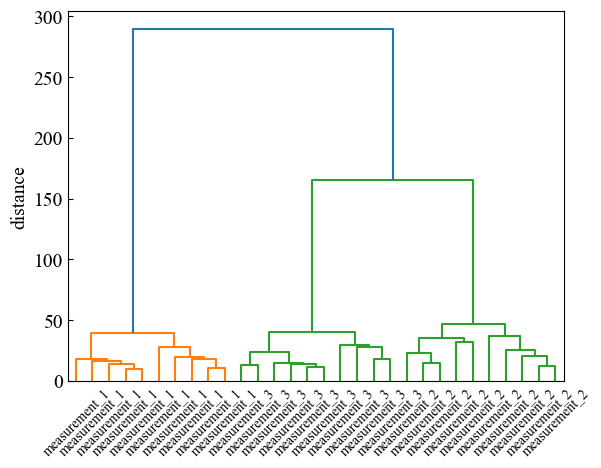

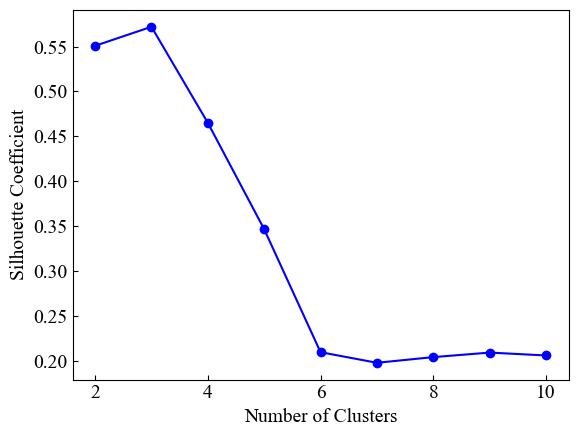

silhouette_coefficient
[0.5507793831633381, 0.5719309222306658, 0.4651512869940412, 0.3468250341792349, 0.2101105489054378, 0.19832918007577127, 0.20462740266258195, 0.20966435266102662, 0.2064628641319137]


In [5]:
# 階層型クラスタリング(ウォード法)
# デンドログラムとシルエット係数
"""
# 表示名に変換する関数を定義
def convert_display_name(filename):
    if "force1" in filename:
        return "measurement_3"
    elif "force2" in filename:
        return "measurement_2"
    elif "force3" in filename:
        return "measurement_1"
    else:
        return filename
"""
# デンドログラムに表示する名前を変換
display_names = [convert_display_name(name) for name in namelist]
                 
# クラスタリングとデンドログラムの作成
Distance = Dis_all.values
darray = distance.squareform(Distance)
result = linkage(darray, method="ward")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
fig = plt.figure()
dendrogram(result, labels=display_names)
plt.ylabel("distance")

# グラフの保存
graph_file_name = os.path.join(graph_save_path, "handrail_dendrogram_ward.png")
plt.savefig(graph_file_name)
plt.show()

# シルエット係数の計算とプロット
plt.cla()
NUM_CLUSTERS_RANGE = range(2, 11)
silhouette_coefficient = []
davies_bouldin_index = []

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.direction"] = "in"

for num in NUM_CLUSTERS_RANGE:
    labels = fcluster(result, t=num, criterion="maxclust")
    silhouette_coefficient.append(silhouette_score(Distance, labels, metric="precomputed"))
    davies_bouldin_index.append(davies_bouldin_score(Distance, labels))

p0, = plt.plot(NUM_CLUSTERS_RANGE, silhouette_coefficient, 'bo-', label="Silhouette Coefficient")
lines = [p0]

graph_file_name = os.path.join(graph_save_path, "handrail_dendrogram_ward_silhouette_coefficient.png")
plt.savefig(graph_file_name)
plt.show()

print("silhouette_coefficient")
print(silhouette_coefficient)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


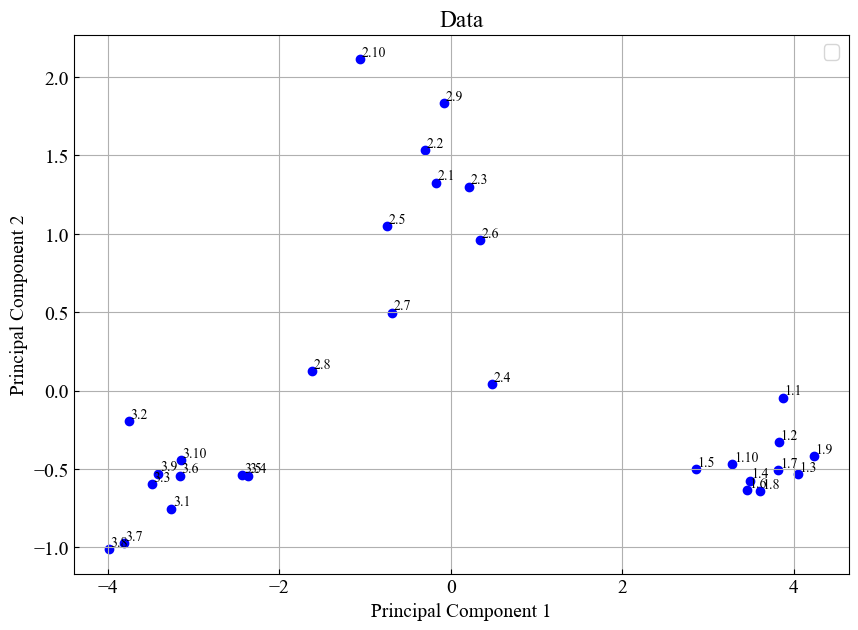

In [17]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob
import os

# グラフの保存先ディレクトリ
graph_save_path = r"E:\てすりとキネクト（てすり）\データ分析\階層型クラスタリング"

# データファイルのパスを取得
data_files = glob.glob(os.path.join(graph_save_path, "Unified*.xlsx"))

# データを格納するリスト
x_data, y_data, z_data = [], [], []

for file in data_files:
    df = pd.read_excel(file, engine='openpyxl')
    x_data.append(df.iloc[:, 0])  # X軸のデータ
    y_data.append(df.iloc[:, 1])  # Y軸のデータ
    z_data.append(df.iloc[:, 2])  # Z軸のデータ

# データを結合
all_data = np.column_stack((x_data, y_data, z_data))

# PCAの実行
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_data)

# 結果をデータフレームに変換
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# 表示名に変換する関数を定義
def convert_display_name(filename):
    if "force1" in filename:
        return "3"
    elif "force2" in filename:
        return "2"
    elif "force3" in filename:
        return "1"
    else:
        return filename

# ファイル名に対応する番号を振る
label_dict = {}
for file in data_files:
    label = convert_display_name(file)
    if label not in label_dict:
        label_dict[label] = 0
    label_dict[label] += 1

    # 例: measurement_3_1, measurement_3_2 など
    pca_df.loc[pca_df.shape[0] - len(data_files) + data_files.index(file), 'label'] = f"{label}.{label_dict[label]}"

# PCAの結果をプロット
plt.figure(figsize=(10, 7))
for idx, row in pca_df.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color = "b")
    plt.text(row['PC1']+0.02, row['PC2']+0.02, row['label'], fontsize=10)  # プロット近くに番号を表示
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data')
plt.legend()
plt.grid(True)

# グラフの保存
pca_graph_file_name = os.path.join(graph_save_path, "pca_result.png")
plt.savefig(pca_graph_file_name)


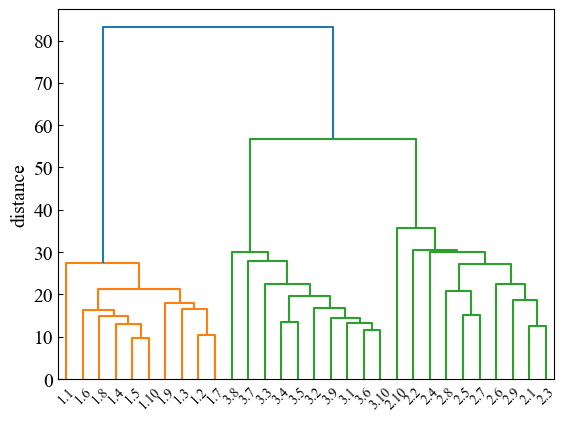

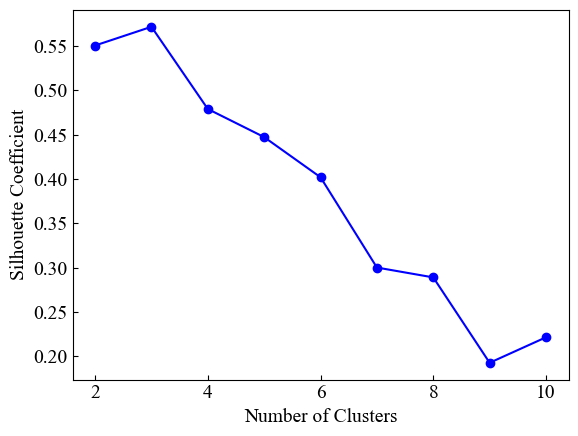

silhouette_coefficient
[0.5507793831633381, 0.5719309222306658, 0.47906632772086133, 0.4473053588803006, 0.4019466277447291, 0.29998634380063577, 0.2888449068611231, 0.1923970555703461, 0.2211988893983604]
davies_bouldin_index
[0.48573136010073753, 0.43702243177932315, 0.5017393908565829, 0.6458655322146114, 0.6064265483560292, 0.5746597093751115, 0.5499242502821253, 0.562508138414825, 0.5083117391696593]


In [16]:
# 階層型クラスタリング(平均法)
# デンドログラムとシルエット係数
# 各データにindexを表示したVer

# 表示名に変換する関数を定義
def convert_display_name_with_index(filename, index_dict):
    base_name = None
    if "force1" in filename:
        base_name = "3"
    elif "force2" in filename:
        base_name = "2"
    elif "force3" in filename:
        base_name = "1"
    else:
        return filename

    if base_name not in index_dict:
        index_dict[base_name] = 0
    index_dict[base_name] += 1
    return f"{base_name}.{index_dict[base_name]}"

# インデックス辞書を初期化
index_dict = {}

# デンドログラムに表示する名前を変換
display_names = [convert_display_name_with_index(name, index_dict) for name in namelist]

# クラスタリングとデンドログラムの作成
Distance = Dis_all.values
darray = distance.squareform(Distance)
result = linkage(darray, method="average")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
fig = plt.figure()
dendrogram(result, labels=display_names)
plt.ylabel("distance")

# グラフの保存
graph_file_name = os.path.join(graph_save_path, "handrail_dendrogram.png")
plt.savefig(graph_file_name)
plt.show()

# シルエット係数の計算とプロット
plt.cla()
NUM_CLUSTERS_RANGE = range(2, 11)
silhouette_coefficient = []
davies_bouldin_index = []

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.direction"] = "in"

for num in NUM_CLUSTERS_RANGE:
    labels = fcluster(result, t=num, criterion="maxclust")
    silhouette_coefficient.append(silhouette_score(Distance, labels, metric="precomputed"))
    davies_bouldin_index.append(davies_bouldin_score(Distance, labels))

p0, = plt.plot(NUM_CLUSTERS_RANGE, silhouette_coefficient, 'bo-', label="Silhouette Coefficient")
lines = [p0]

# グラフの保存
graph_file_name = os.path.join(graph_save_path, "handrail_dendrogram_silhouette_coefficient.png")
plt.savefig(graph_file_name)
plt.show()

print("silhouette_coefficient")
print(silhouette_coefficient)

print("davies_bouldin_index")
print(davies_bouldin_index)